In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
tqdm.pandas()

from one.api import ONE

from util import _get_targets

In [2]:
df_sessions = pd.read_parquet('metadata/sessions.pqt')

In [9]:
valid_targets = [
    'VTA',
    'SNc',
    'DR',
    'MR',
    'LC',
    'NBM',
    'SI',
    'PPT'
]

df_targets = df_sessions.explode(column='target').dropna(subset='target')
df_targets = df_targets.query('target.isin(@valid_targets) and NM != "none"')
df_targets['target_NM'] = df_targets.apply(lambda x: '-'.join([x['target'], x['NM']]), axis='columns')

/tmp/ipykernel_31672/1889500082.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  n_mice = df_targets.groupby('target_NM').apply(lambda x: len(x['subject'].unique()))


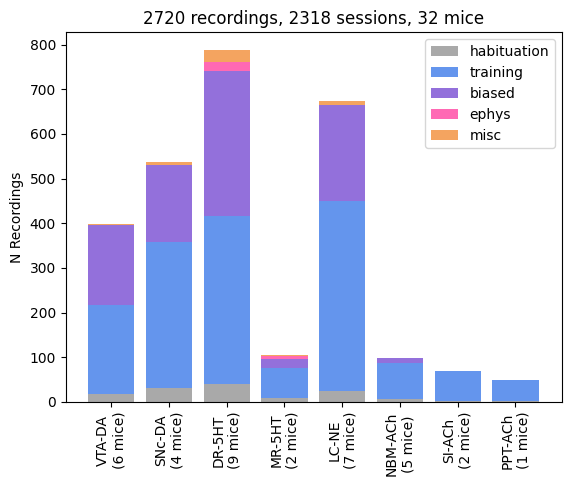

In [37]:
fig, ax = plt.subplots()

positions = {
    'VTA-DA': 0,
    'SNc-DA': 1,
    'DR-5HT': 2,
    'MR-5HT': 3,
    'LC-NE': 4,
    'NBM-ACh': 5,
    'SI-ACh': 6,
    'PPT-ACh': 7
}

session_types = {
    'habituation': 'darkgray',
    'training': 'cornflowerblue',
    'biased': 'mediumpurple', 
    'ephys': 'hotpink',
    'misc':  'sandybrown'
}

df_n = df_targets.pivot_table(columns='session_type', index='target_NM', aggfunc='size', fill_value=0)
xpos = [positions[target_NM] for target_NM in df_n.index]
ypos = np.zeros(len(df_n))
width = 0.8
for session_type, color in session_types.items():
    n_sessions = df_n[session_type].values
    ax.bar(xpos, n_sessions, bottom=ypos, width=width, color=color, label=session_type)
    ypos += n_sessions
ax.set_xticks(list(positions.values()))
n_mice = df_targets.groupby('target_NM').apply(lambda x: len(x['subject'].unique()))
ax.set_xticklabels(['%s\n(%d mice)' % (k, n_mice.loc[k]) for k in positions.keys()])
ax.set_xlim(right=max(positions.values()) + width)
ax.tick_params(axis='x', rotation=90)
ax.set_yticks(np.arange(0, np.ceil(max(ypos) / 100) + 1) * 100)
ax.set_ylabel('N Recordings')
ax.legend()

n_recordings = len(df_targets)
n_sessions = len(df_targets.groupby('eid'))
n_mice = len(df_targets.groupby('subject'))
ax.set_title(f'{n_recordings} recordings, {n_sessions} sessions, {n_mice} mice')

fig.savefig('figures/sessions.svg')

In [34]:
['%s\n%d' % (k, n_mice.loc[k]) for k in positions.keys()]

['VTA-DA/n6',
 'SNc-DA/n4',
 'DR-5HT/n9',
 'MR-5HT/n2',
 'LC-NE/n7',
 'NBM-ACh/n5',
 'SI-ACh/n2',
 'PPT-ACh/n1']

In [24]:
df_mice = pd.DataFrame(data=df_targets.groupby('target_NM').apply(lambda x: len(x['subject'].unique())), columns=['N Mice'])

/tmp/ipykernel_31672/26313705.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_mice = pd.DataFrame(data=df_targets.groupby('target_NM').apply(lambda x: len(x['subject'].unique())), columns=['N Mice'])


/tmp/ipykernel_31672/2384004470.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  n_mice = df_targets.groupby('target_NM').apply(lambda x: len(x['subject'].unique()))


In [29]:
n_mice.loc['VTA-DA']

np.int64(6)